# Real Estate Advertissing Prices Prediction
## Done by


- Afrah Alsharari
- Ahmed Aljmiai

In [4]:
# Necessary imports
import pickle
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score


%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

plt.rcParams["figure.dpi"] = 200





C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_28312/1757652813.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Prepare Utility Function

In [5]:
# calculating distance between two points finind how far the propty from kindom tower

def distance_to_kindom_tower(x1, y1, x2, y2):
    # radians which converts from degrees to radians.
    x1 = radians(x1)
    x2 = radians(x2)
    y1 = radians(y1)
    y2 = radians(y2)

    # Haversine formula
    dlon = x2 - x1
    dlat = y2 - y1
    #print(dlon, dlat)
    a = sin(dlat / 2)**2 + cos(y1) * cos(y2) * sin(dlon / 2)**2

    c = 2 * asin(sqrt(a))

    # Radius of earth Km.
    r = 6371

    # calculate the result
    return(c * r)

kindom_tower = (24.71137943972013, 46.6744023160207) 

## Load scraped Aqar Dataset for Riyadh

In [6]:
with open('riyadh_df.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [7]:
# Adding the distance_to_kindom_tower_Km as a new column to the dataset
d = []
for index, row in df[['location.lat','location.lng']].iterrows():
    d.append(distance_to_kindom_tower(kindom_tower[1],kindom_tower[0],float(row[1]), float(row[0])))
    
df['distance_to_kindom_tower_Km'] = d

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,19675.0,3.381170e+06,2.918538e+05,163905.000000,3.286157e+06,3.471642e+06,3.573772e+06,3.630071e+06
price,19675.0,1.944279e+06,1.991302e+06,900.000000,1.120000e+06,1.350000e+06,2.000000e+06,5.000000e+07
category,19675.0,3.000000e+00,0.000000e+00,3.000000,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
direction_id,19675.0,3.923456e+00,1.775849e+00,1.000000,3.000000e+00,4.000000e+00,6.000000e+00,7.000000e+00
district_id,19675.0,5.738003e+02,1.004651e+02,390.000000,4.720000e+02,5.900000e+02,6.820000e+02,7.180000e+02
city_id,19675.0,2.100000e+01,0.000000e+00,21.000000,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01
age,19675.0,3.666023e+00,8.455062e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,3.600000e+01
apts,19675.0,8.260737e-01,1.197759e+00,0.000000,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+01
area,19675.0,3.885628e+02,2.761550e+02,56.000000,2.700000e+02,3.240000e+02,4.200000e+02,1.377000e+04
backyard,19675.0,8.056925e-01,3.956767e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Feature Engineering

In [9]:
# Remove null values
df.dropna(inplace=True)
# Remove the duplicated rows
df.drop_duplicates(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19675 entries, 0 to 58290
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           19675 non-null  int64  
 1   price                        19675 non-null  int64  
 2   category                     19675 non-null  int64  
 3   district                     19675 non-null  object 
 4   direction                    19675 non-null  object 
 5   city                         19675 non-null  object 
 6   direction_id                 19675 non-null  int64  
 7   district_id                  19675 non-null  int64  
 8   city_id                      19675 non-null  int64  
 9   age                          19675 non-null  float64
 10  apts                         19675 non-null  float64
 11  area                         19675 non-null  int64  
 12  backyard                     19675 non-null  float64
 13  basement        

In [11]:
# Latitude north-south

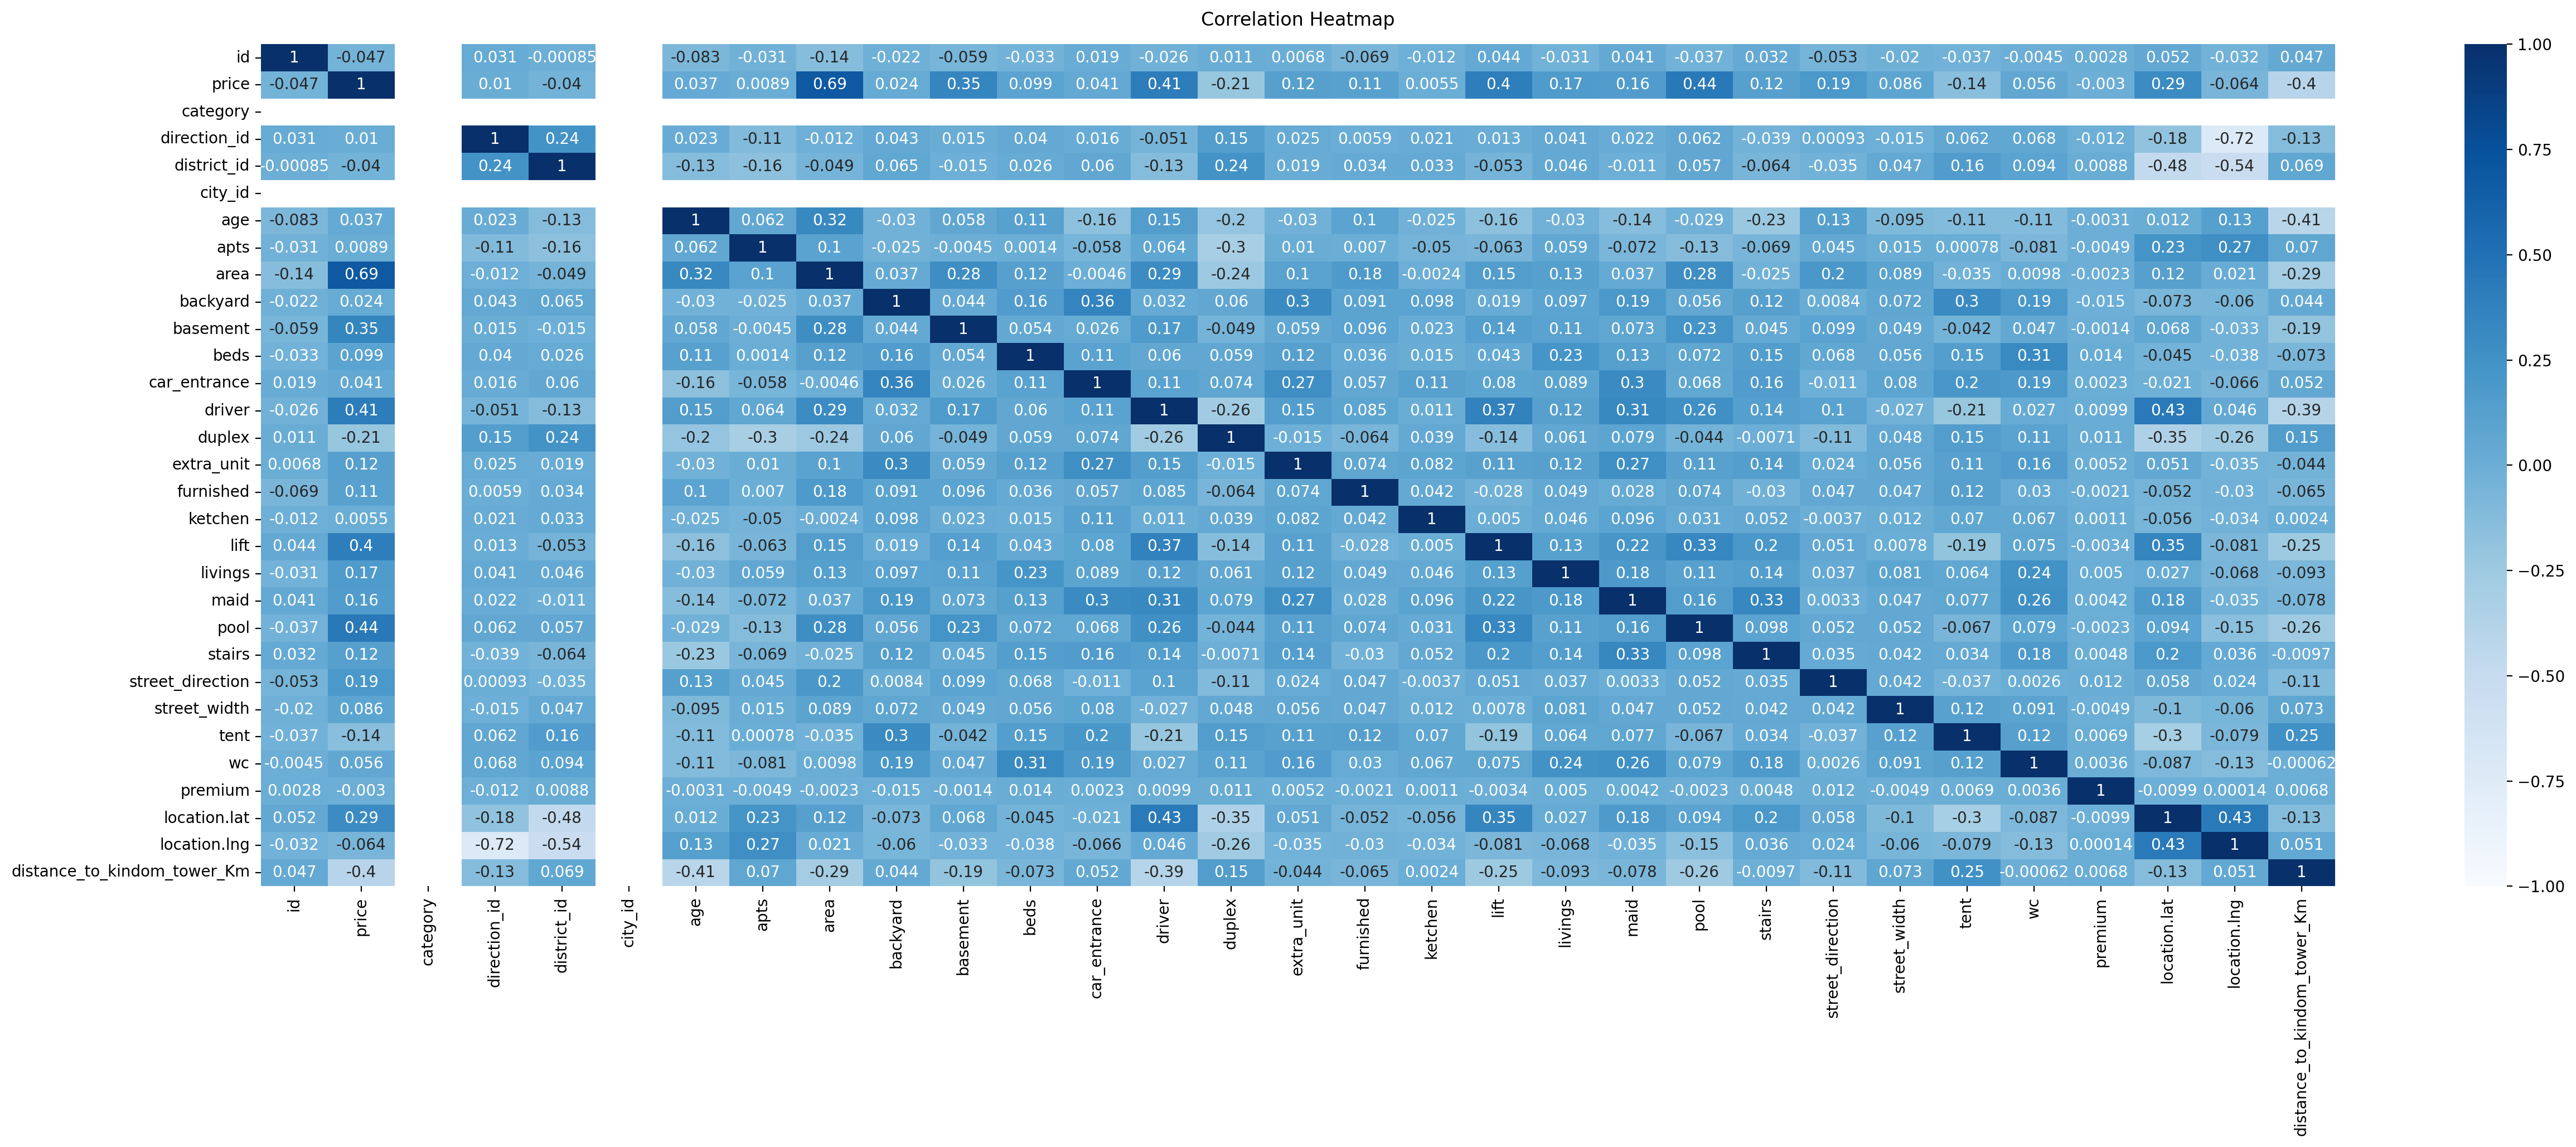

In [12]:
# Checking features correlation
plt.figure(figsize=(30,10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="Blues")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

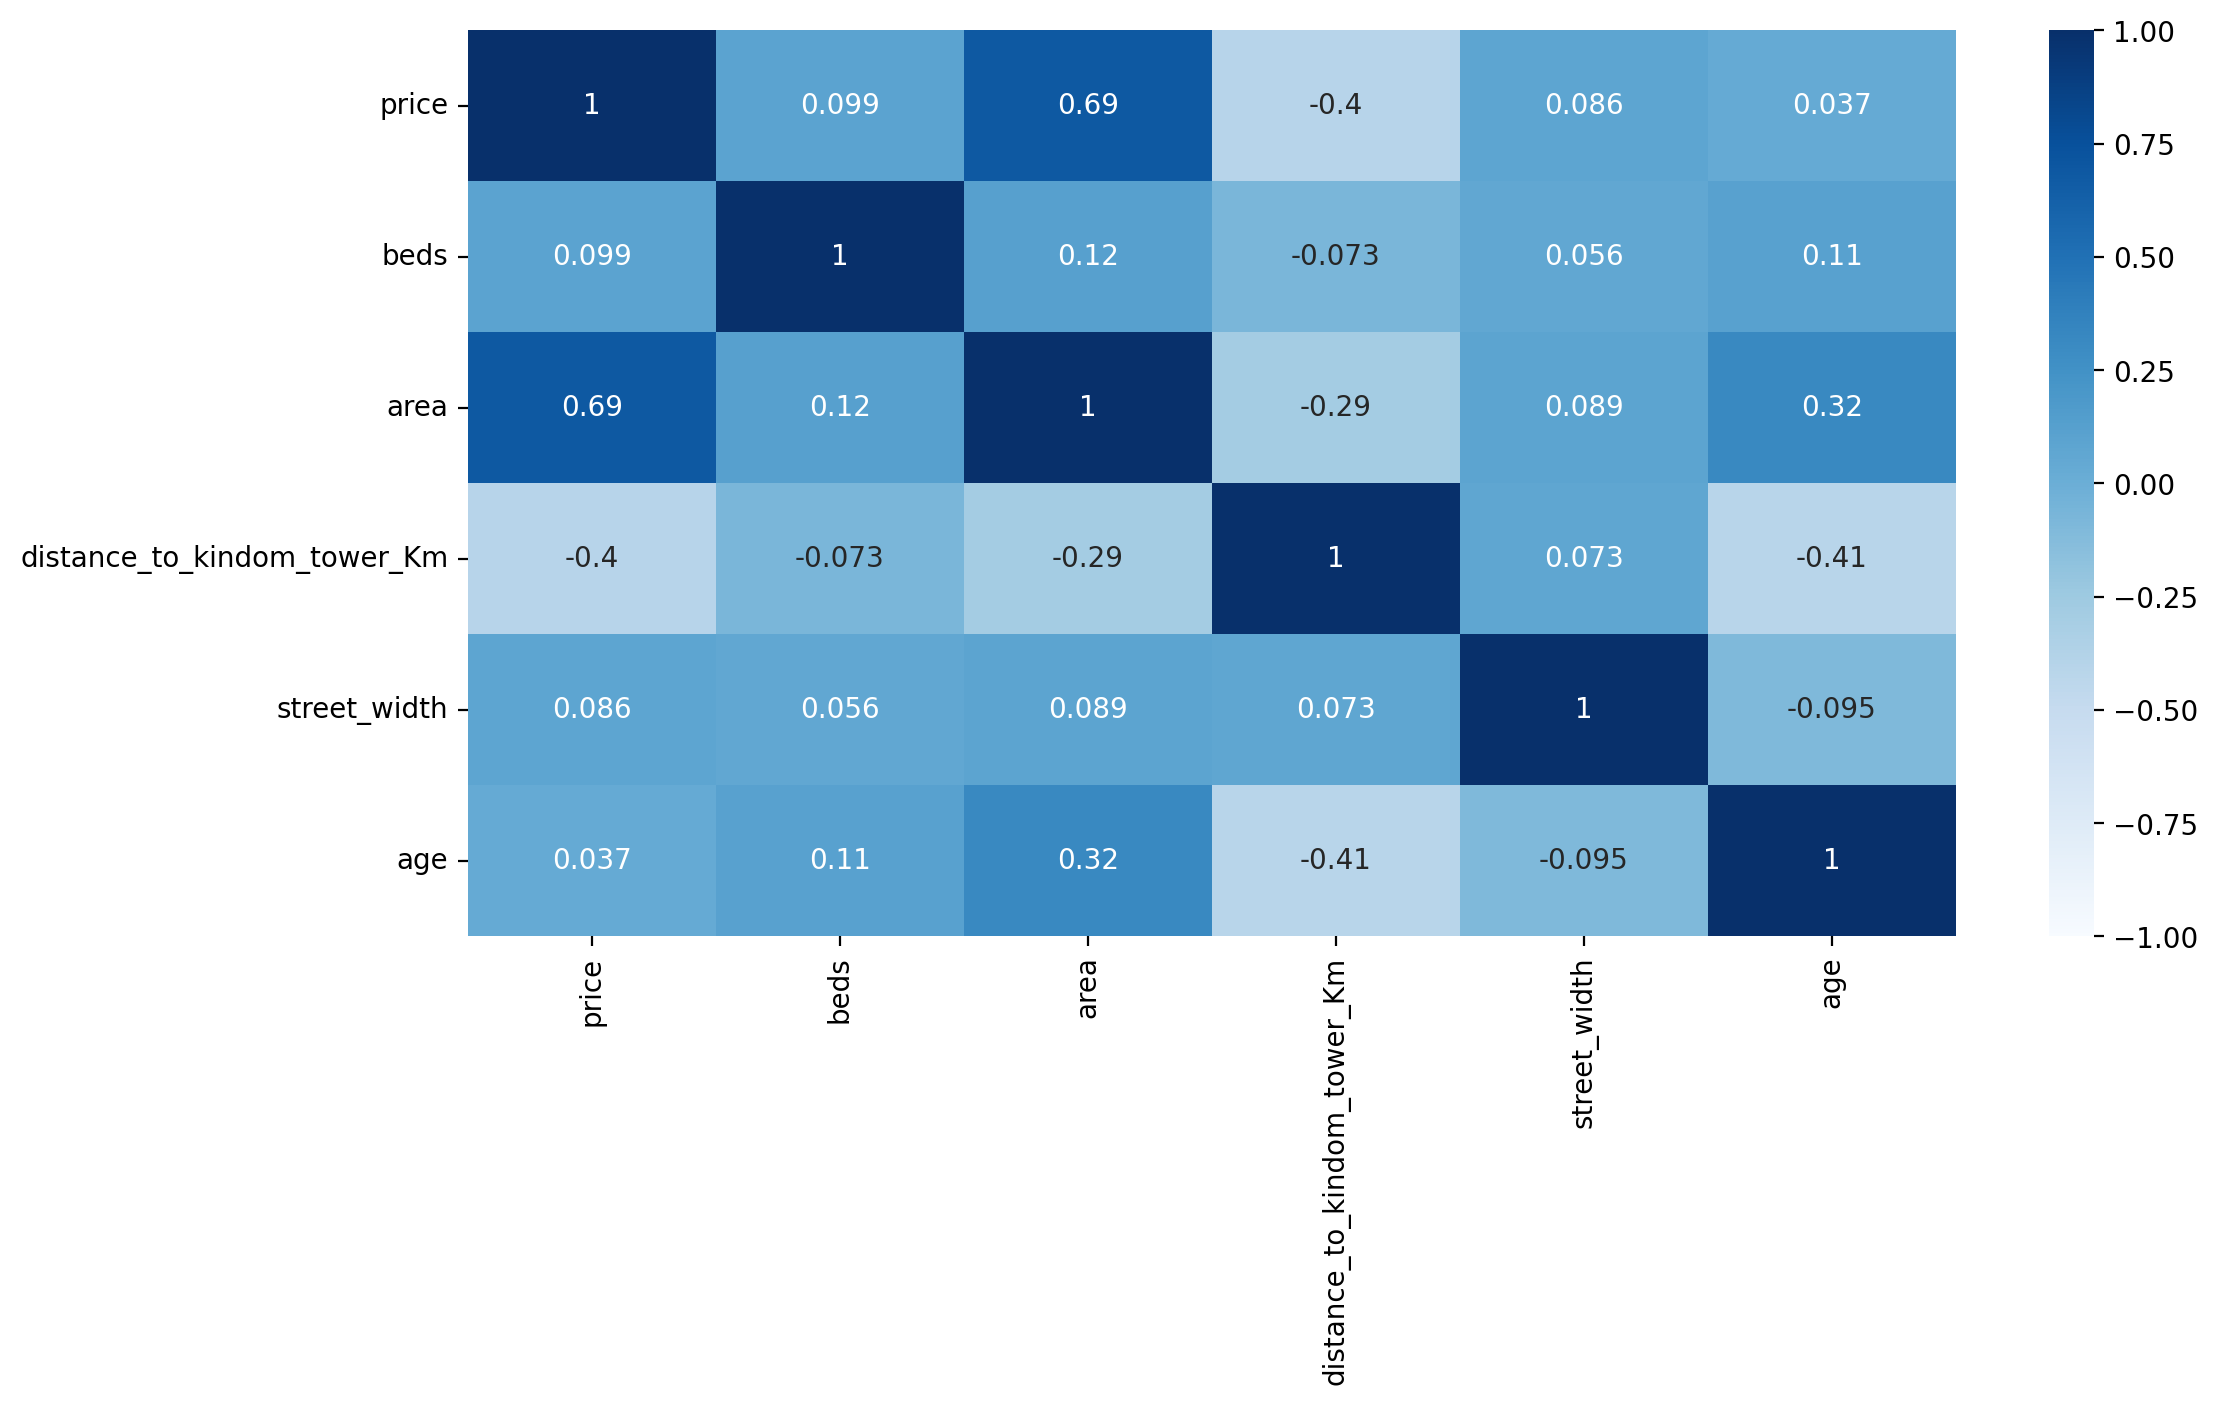

In [13]:
# Checking features correlation for ['price','area','distance_to_kindom_tower_Km', 'street_width', 'age']
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df[['price','beds','area','distance_to_kindom_tower_Km', 'street_width', 'age', 'district']].corr(), vmin=-1, vmax=1, annot=True,cmap='Blues')
plt.show()

In [14]:
# Show the count of each value in district
df.district.value_counts()

حي طويق                        3637
حي الرمال                      2325
حي المونسية                    849 
حي المهدية                     811 
حي عكاظ                        780 
حي بدر                         776 
حي النرجس                      742 
حي العارض                      740 
حي الملقا                      657 
حي الدار البيضاء               545 
حي الحزم                       530 
حي طيبة                        442 
حي القادسية                    430 
حي ظهرة لبن                    348 
حي العزيزية                    338 
حي الياسمين                    318 
حي اليرموك                     299 
حي ظهرة نمار                   272 
حي النهضة                      200 
حي القيروان                    197 
حي قرطبة                       195 
حي اشبيلية                     195 
حي السويدي                     186 
حي حطين                        184 
حي العريجاء الغربية            169 
حي الخليج                      161 
حي ديراب                       156 
حي الصحافة                  

In [15]:
# Show number of values in district attribute to replace which has less than 10
dlt_counts =df.district.value_counts()
(dlt_counts >10).value_counts()

True     94
False    40
Name: district, dtype: int64

In [16]:
# Get indexes of values in district attribute which has less than 10
other_dlt = list(dlt_counts[dlt_counts <= 10].index)

# Replace thoes indexes in district attribute with 'اخرى'
df['district']= df['district'].replace(other_dlt, 'اخرى')
df.district.value_counts()

حي طويق                3637
حي الرمال              2325
حي المونسية            849 
حي المهدية             811 
حي عكاظ                780 
حي بدر                 776 
حي النرجس              742 
حي العارض              740 
حي الملقا              657 
حي الدار البيضاء       545 
حي الحزم               530 
حي طيبة                442 
حي القادسية            430 
حي ظهرة لبن            348 
حي العزيزية            338 
حي الياسمين            318 
حي اليرموك             299 
حي ظهرة نمار           272 
حي النهضة              200 
حي القيروان            197 
حي اشبيلية             195 
حي قرطبة               195 
حي السويدي             186 
حي حطين                184 
حي العريجاء الغربية    169 
حي الخليج              161 
اخرى                   158 
حي الصحافة             156 
حي ديراب               156 
حي الشرق               145 
حي النسيم الغربي       134 
حي الشفا               131 
حي الجنادرية           119 
حي النظيم              114 
حي الزهرة              88  
حي السعادة          

## Removed outliers
#### Show The Box Plot For Numerical Attributes

<AxesSubplot:xlabel='location.lat'>

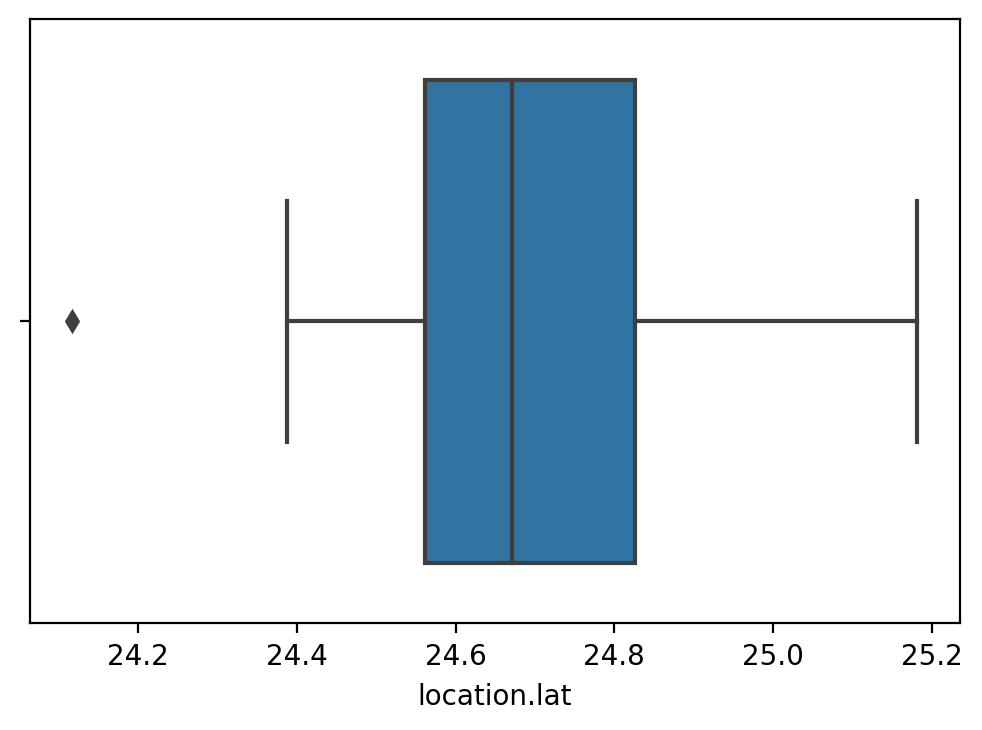

In [17]:
sns.boxplot(x=df['location.lat'])

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_28312/2557106176.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot(x=df[df['location.lat'] > 24.5][df['location.lat'] < 24.85]['location.lat'])


<AxesSubplot:xlabel='location.lat'>

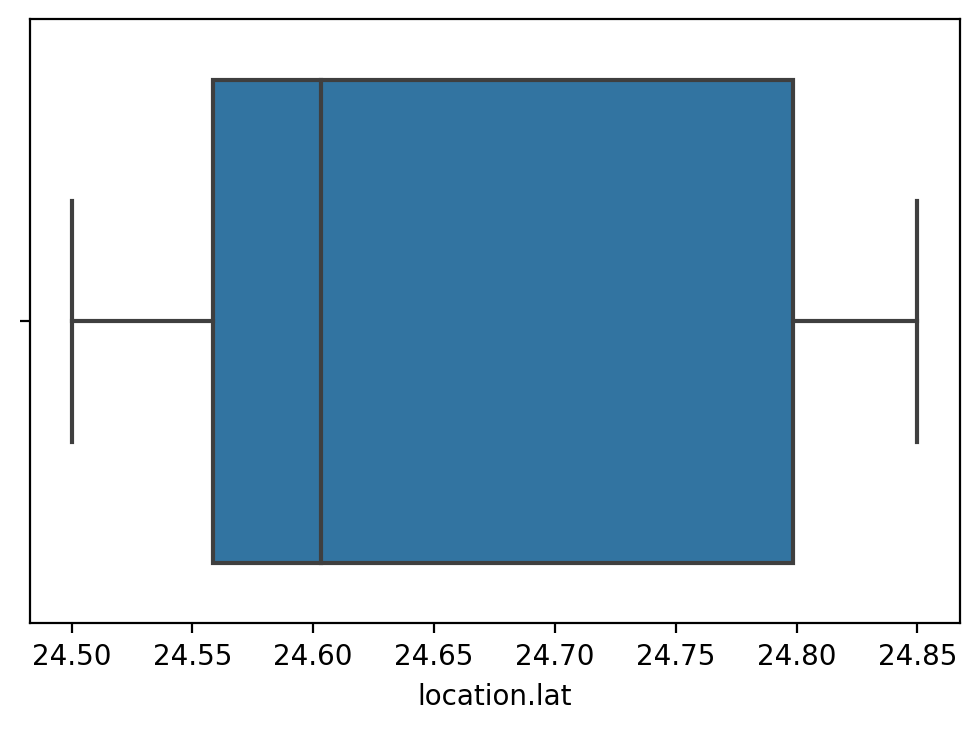

In [18]:
# Remove outliers in the location.lat attribute
sns.boxplot(x=df[df['location.lat'] > 24.5][df['location.lat'] < 24.85]['location.lat'])

<AxesSubplot:xlabel='distance_to_kindom_tower_Km'>

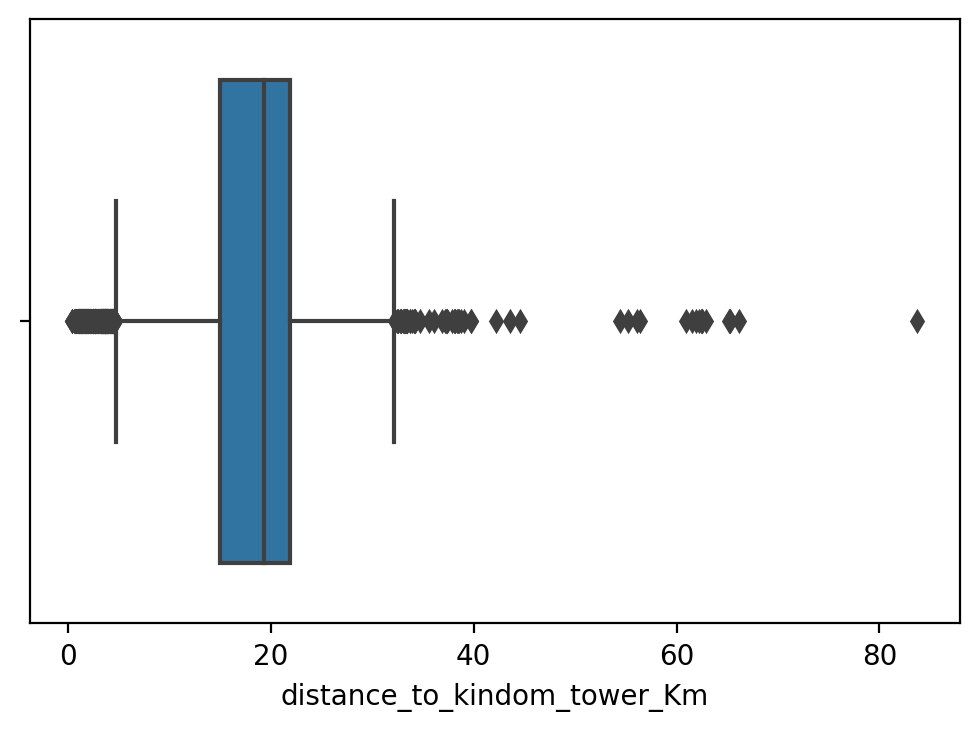

In [19]:
sns.boxplot(x=df['distance_to_kindom_tower_Km'])

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_28312/3991756471.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot(x=df[df['distance_to_kindom_tower_Km'] > 6][df['distance_to_kindom_tower_Km'] < 30]['distance_to_kindom_tower_Km'])


<AxesSubplot:xlabel='distance_to_kindom_tower_Km'>

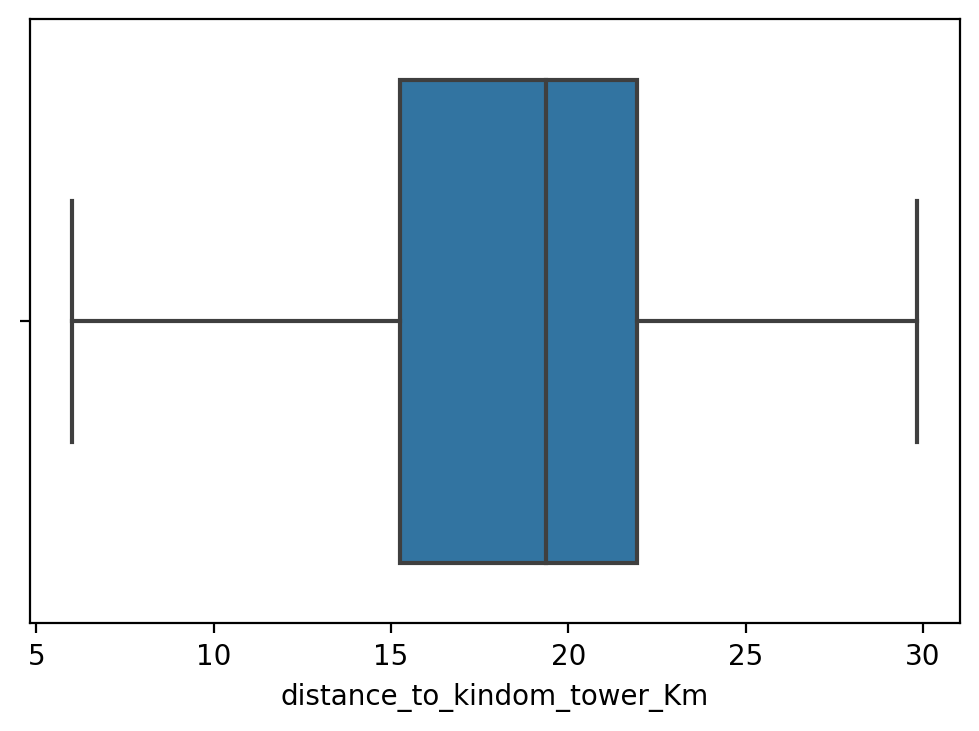

In [20]:
sns.boxplot(x=df[df['distance_to_kindom_tower_Km'] > 6][df['distance_to_kindom_tower_Km'] < 30]['distance_to_kindom_tower_Km'])

In [21]:
df[df['distance_to_kindom_tower_Km'] > 6][df['distance_to_kindom_tower_Km'] < 30]['distance_to_kindom_tower_Km'].count()

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_28312/1247842206.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['distance_to_kindom_tower_Km'] > 6][df['distance_to_kindom_tower_Km'] < 30]['distance_to_kindom_tower_Km'].count()


19260

<AxesSubplot:xlabel='age'>

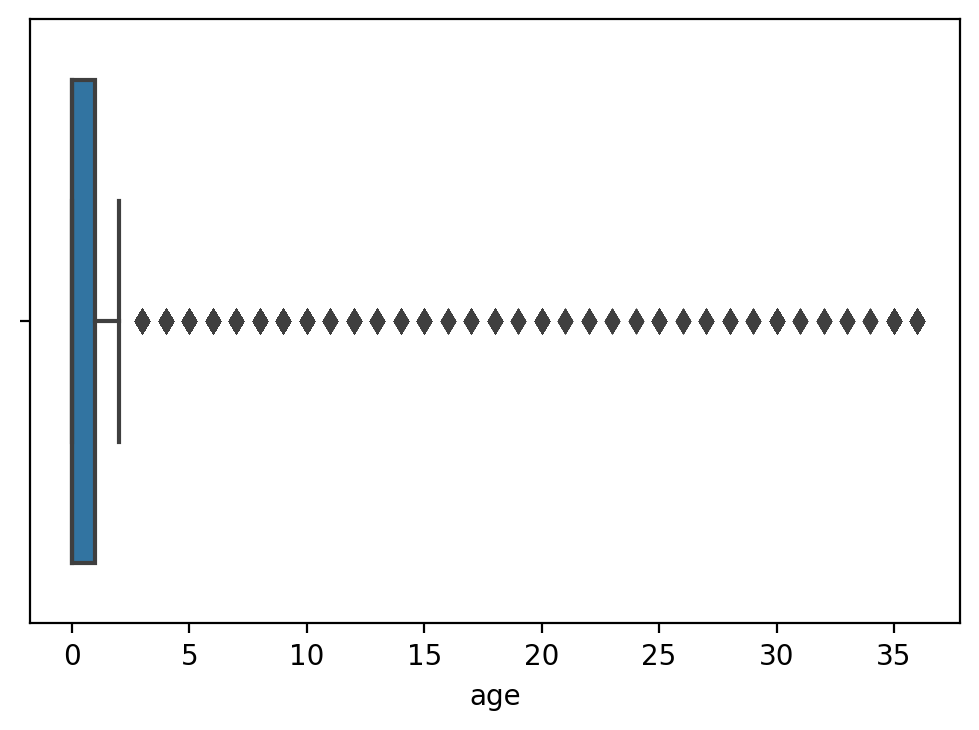

In [22]:
sns.boxplot(x=df['age'])

<AxesSubplot:xlabel='age'>

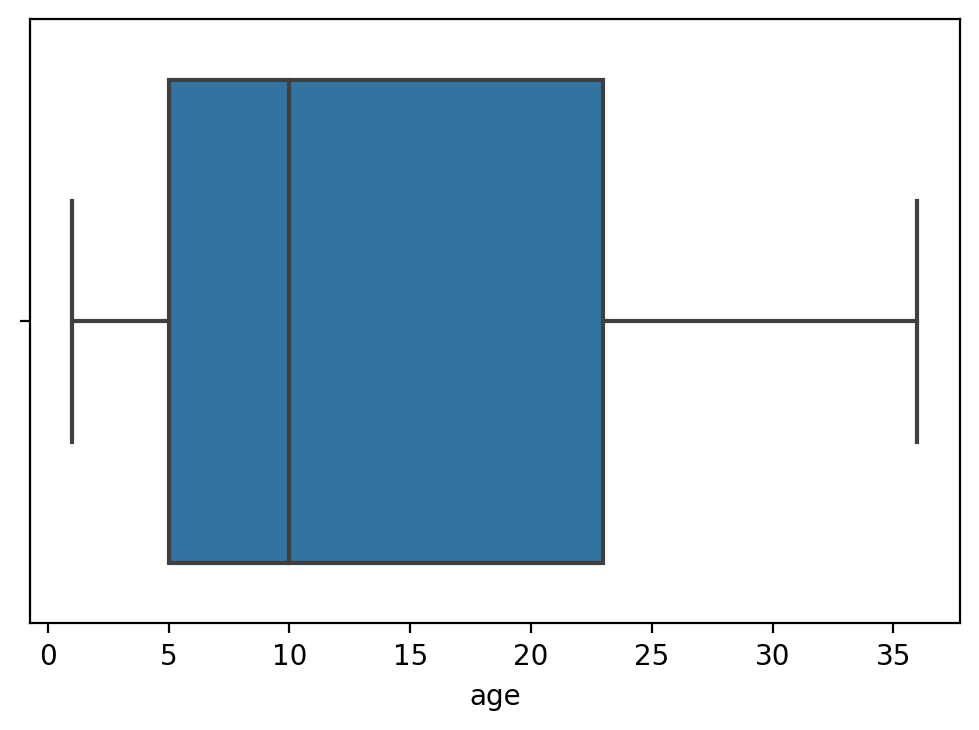

In [23]:
sns.boxplot(x=df[df['age'] > 0]['age'])

<AxesSubplot:xlabel='area'>

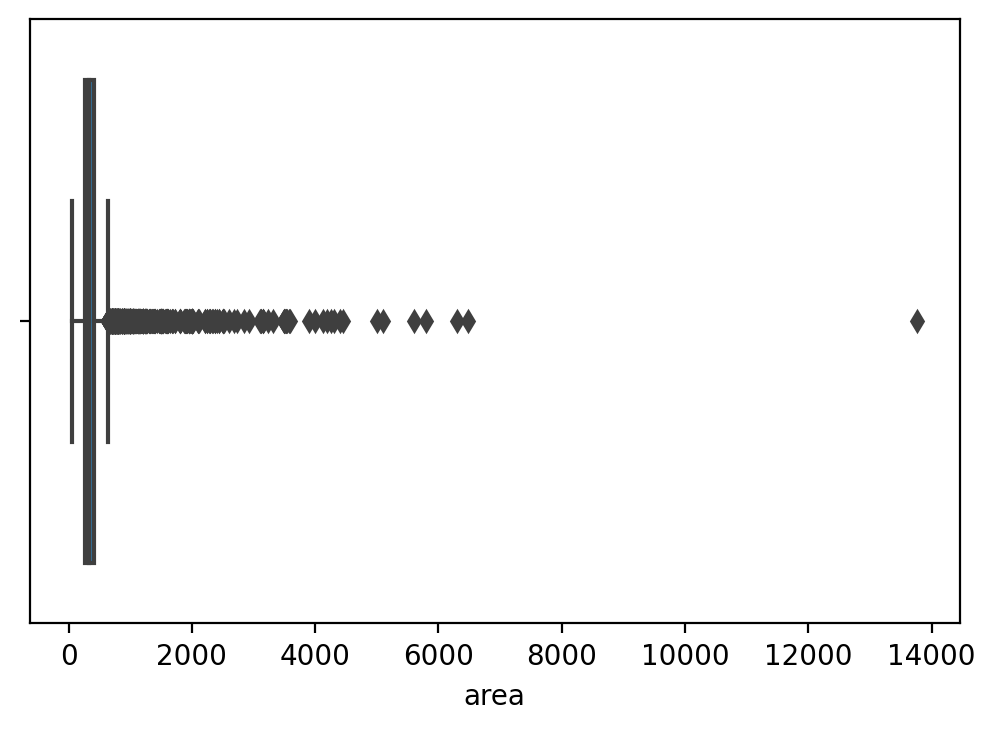

In [24]:
sns.boxplot(x=df['area'])

<AxesSubplot:xlabel='price'>

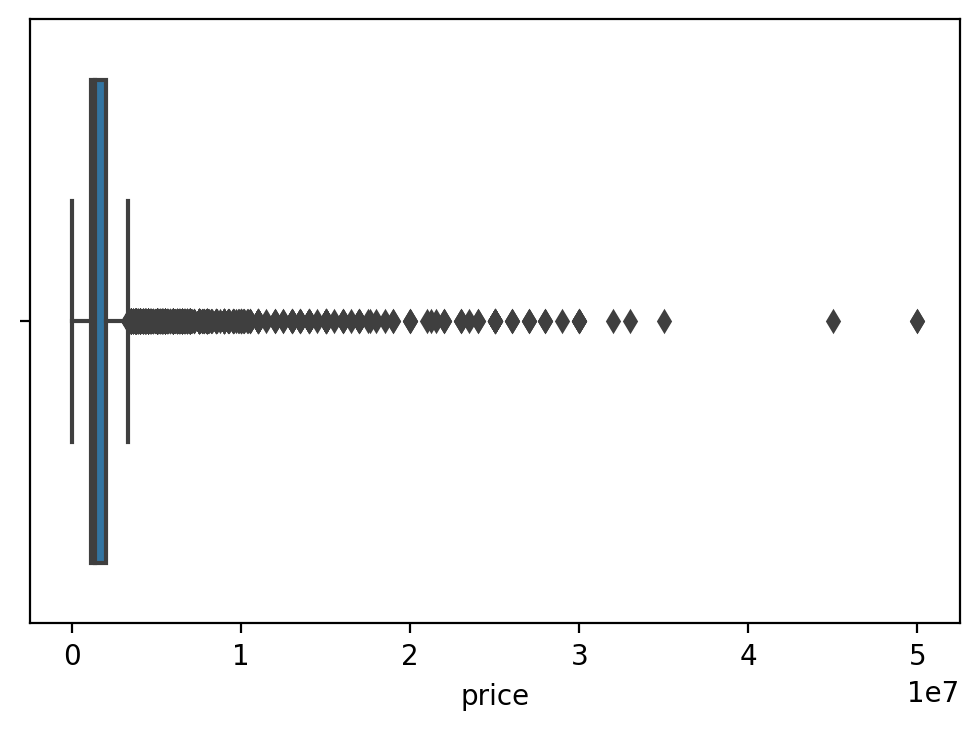

In [25]:
sns.boxplot(x=df['price'])

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_28312/2305422111.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot(x=df[df['price'] < 10000000][df['price'] > 500000]['price'])


<AxesSubplot:xlabel='price'>

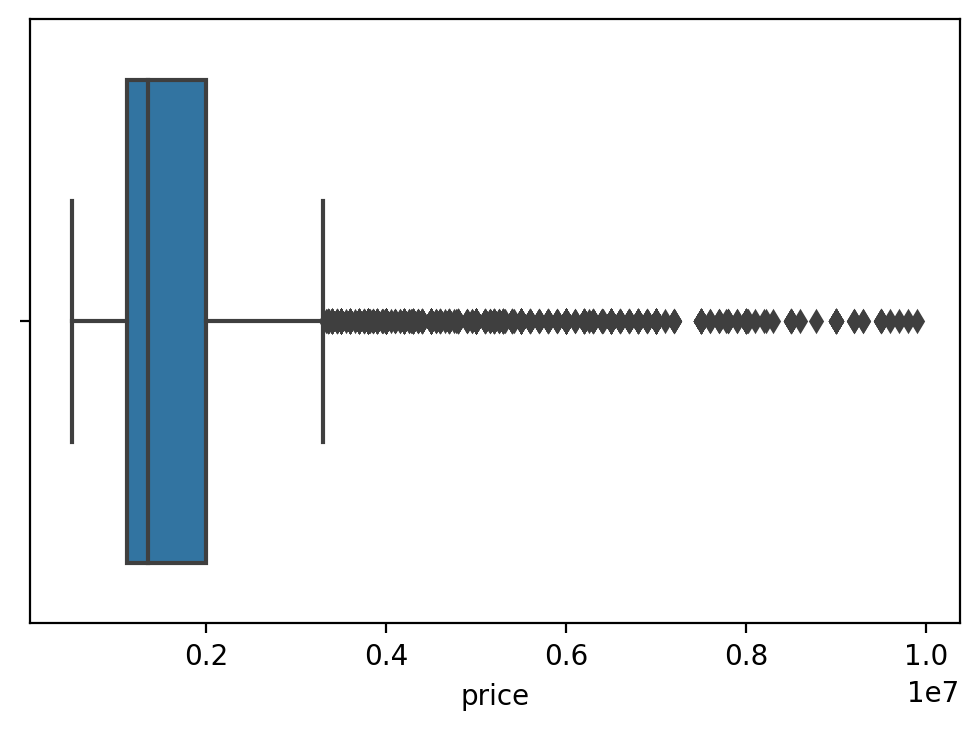

In [26]:
sns.boxplot(x=df[df['price'] < 10000000][df['price'] > 500000]['price'])

In [27]:
#removing outliers from area and age
dfa = df[df['area'] <= 4000][df['area'] >= 100][df['area'] > 0]

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_28312/2490674804.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfa = df[df['area'] <= 4000][df['area'] >= 100][df['area'] > 0]


In [28]:
dfa.count()

id                             19660
price                          19660
category                       19660
district                       19660
direction                      19660
city                           19660
direction_id                   19660
district_id                    19660
city_id                        19660
age                            19660
apts                           19660
area                           19660
backyard                       19660
basement                       19660
beds                           19660
car_entrance                   19660
driver                         19660
duplex                         19660
extra_unit                     19660
furnished                      19660
ketchen                        19660
lift                           19660
livings                        19660
maid                           19660
pool                           19660
stairs                         19660
street_direction               19660
s

<AxesSubplot:xlabel='area'>

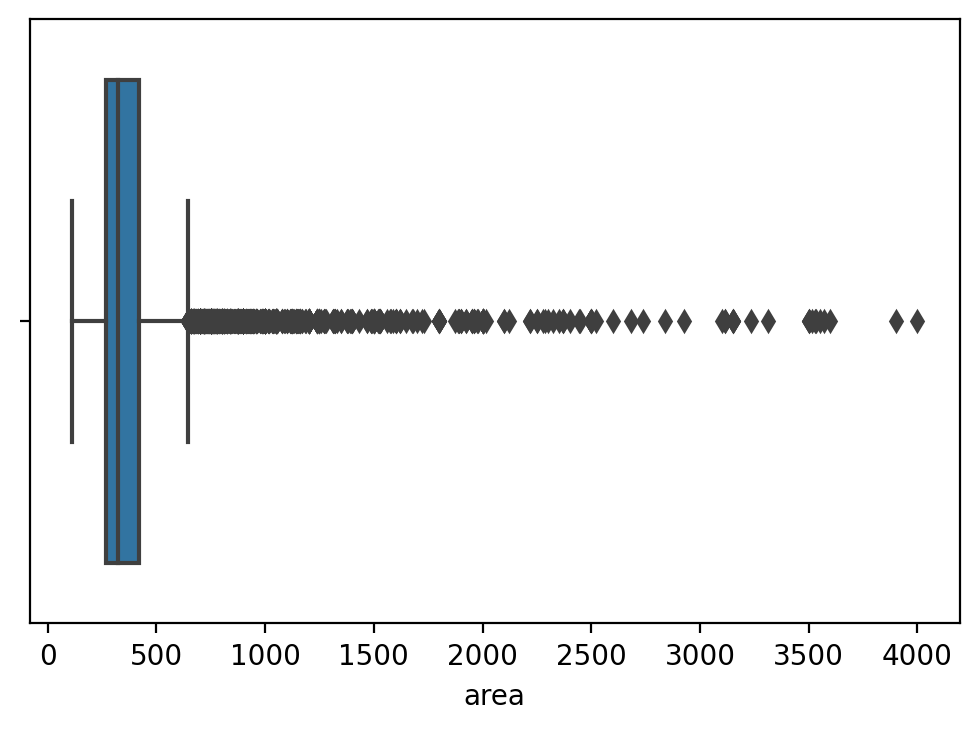

In [29]:
sns.boxplot(x=dfa['area'])

In [30]:
# Show the summary statistics of area attribute
dfa.area.describe()

count    19660.000000
mean     385.099695  
std      231.932815  
min      112.000000  
25%      270.000000  
50%      324.000000  
75%      420.000000  
max      4000.000000 
Name: area, dtype: float64

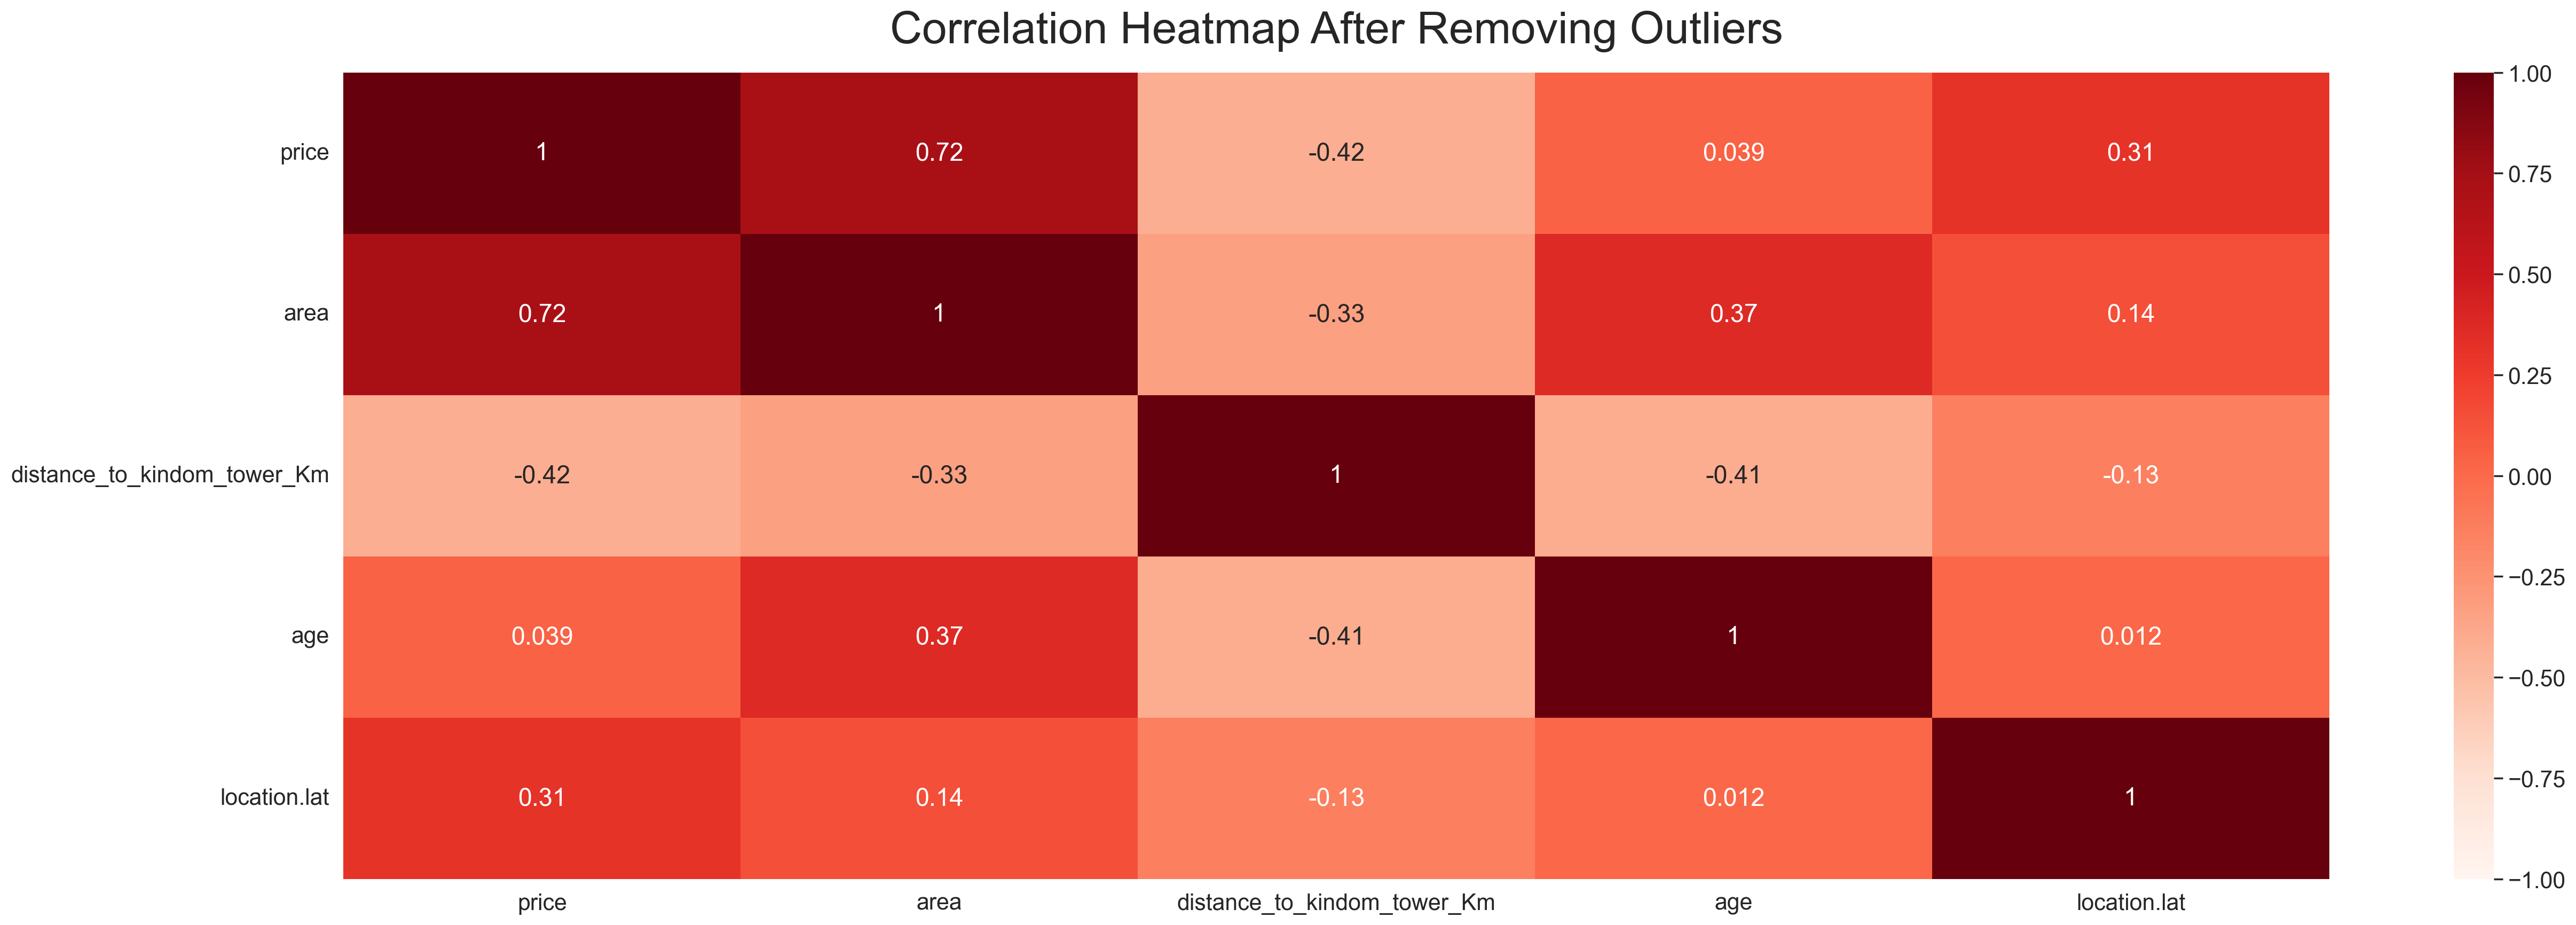

In [31]:
# Checking features correlation
sns.set(font_scale=1.4)
plt.figure(figsize=(30,10))
heatmap = sns.heatmap(dfa[['price','area','distance_to_kindom_tower_Km', 'age', 'location.lat']].corr(), vmin=-1, vmax=1, annot=True, cmap="Reds")
heatmap.set_title('Correlation Heatmap After Removing Outliers', fontdict={'fontsize':30}, pad=20);
plt.show()

There was problem with the converting to numbers using get_dummies method from pandas, the problem was after converting and create new column the data was contains uint8 datatype and that is not accepted in the model and was giving me error after specifing the datatype it worKed nicely

In [65]:
#get dummies featuers 
dum_df = pd.get_dummies(dfa.drop(columns=['city']), columns = ['district','direction'],dtype='int64')

## Modeling

In [66]:
#X = dummies_subset_nona_nodup_riyadh.drop('price',axis=1)
X = dum_df.drop(columns=['price'])
y = dum_df['price']
from sklearn.model_selection import train_test_split


In [69]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''

     # perform train/val split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24) # "= \ to coinsder this line with the above one"
    
    # fit linear regression to training data
    lr_model = LinearRegression() 
    lr_model.fit(X_train, y_train)
    model=lr_model
    
    # fit Ridge regression 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    lm_reg = Ridge(alpha=2)
    lm_reg.fit(X_scaled,y)


    
    # score fit model on validation data
    val_score_linear = cross_val_score(lr_model, X, y, cv = 5).mean()
    val_score_rid = cross_val_score(lm_reg, X, y, cv = 5).mean()
    
    # report results

    print(f'Linear Regression test R^2: {lr_model.score(X_test, y_test):.3f}')
    print('\nCV for Linear model score was:', val_score_linear)
#     X_poly_test = poly_reg.fit_transform(X_test)
    print(f'\nRidge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')
#     print(X_poly_test)
    print('\nCV for Ridge model was score was:', val_score_rid)
#     print('Feature coefficient results: \n')
#     for feature, coef in zip(X.columns, lr_model.coef_):
#         print(feature, ':', f'{coef:.2f}') # "means 2 decimal points"

In [70]:
#after taking out outliers in area
split_and_validate(X,y)

Linear Regression test R^2: 0.734

CV for Linear model score was: 0.752184902146321

Ridge Regression test R^2: 0.740

CV for Ridge model was score was: 0.7521529869278568


In [72]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x) # "regression prediction"

    plt.subplot(1, 3, 1)
    plt.scatter(x,y) # "scatter"
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res) # "scatter supposed to have no pattern"
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt) # "normal qq plot"
    plt.title("Normal Q-Q plot")

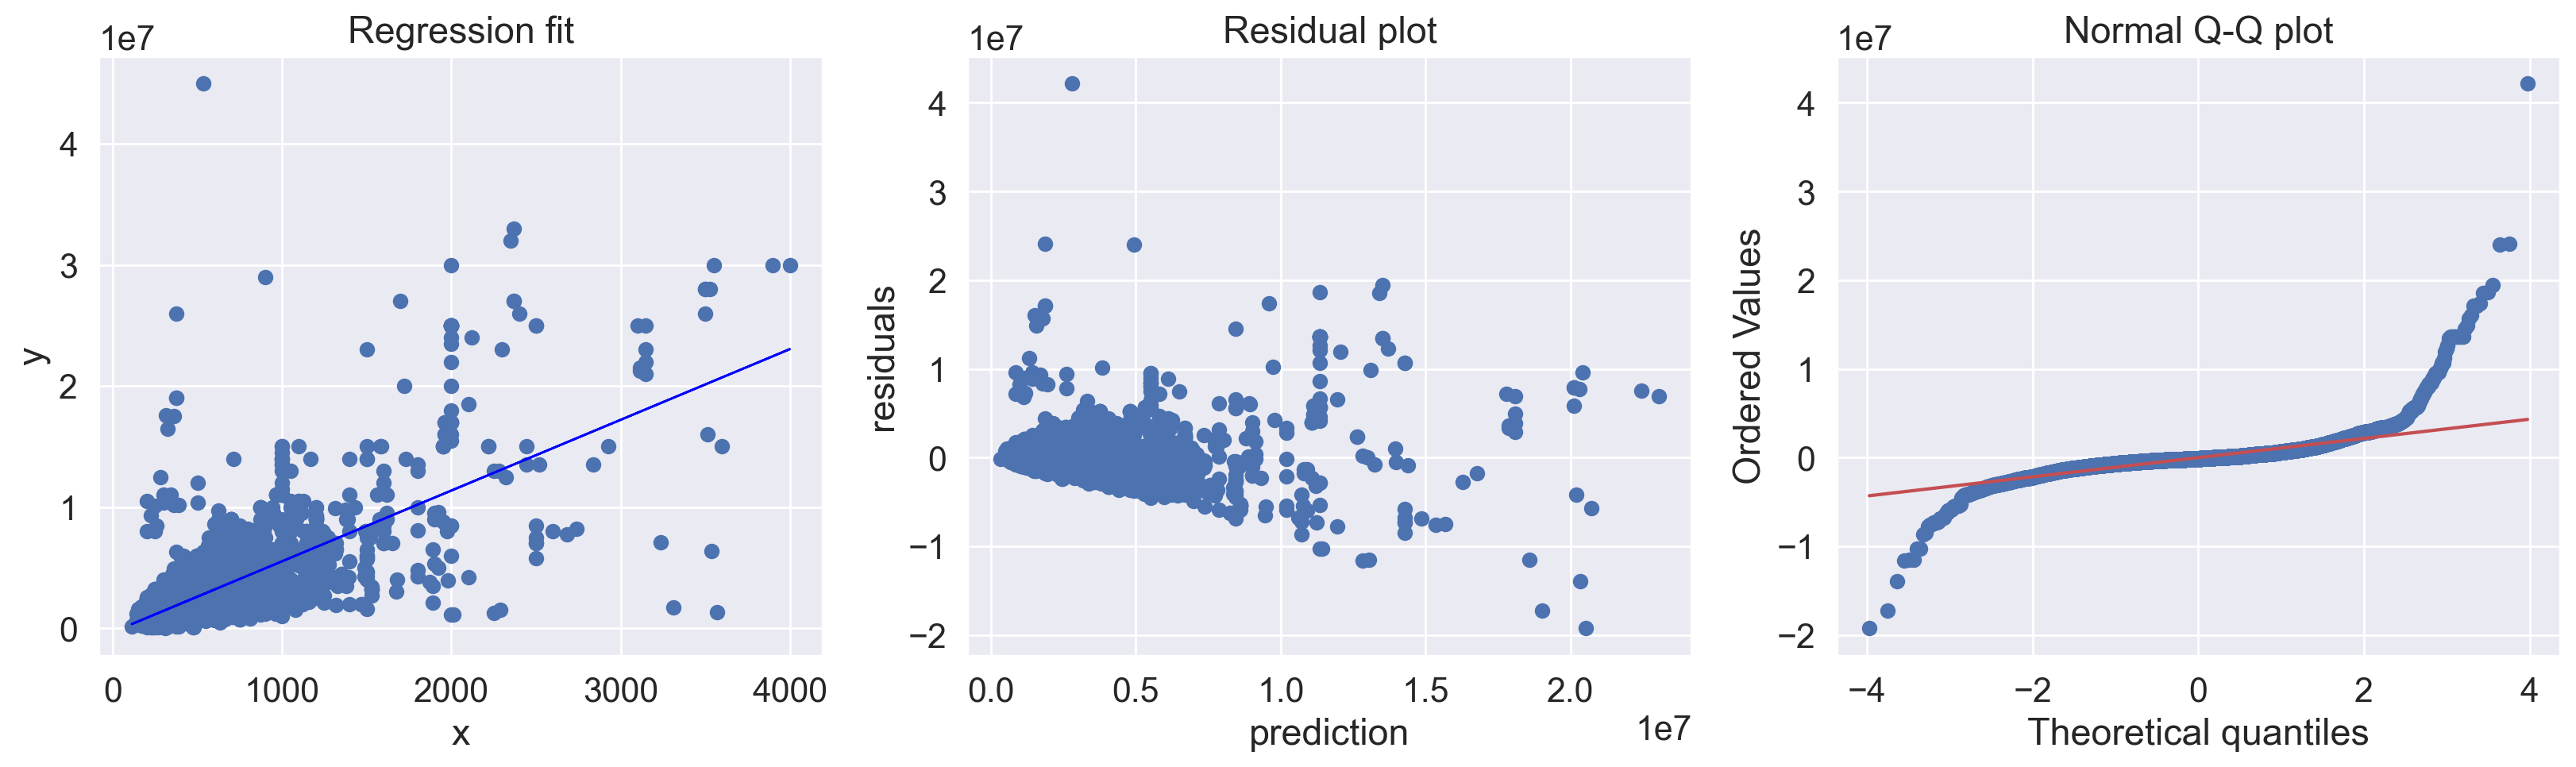

In [73]:
diagnostic_plot(np.array(X['area']).reshape(-1, 1), y)

In [74]:
lr = LinearRegression()
fit = lr.fit(X,y) # for later use

In [75]:
lm = LinearRegression() # construct LinearRegression model object
lm.fit(X, y) #fit model to our choice of features

LinearRegression()

In [76]:
# extract feature coefficients and intercept from fit model
print(lm.intercept_)
print(lm.coef_)

-17604767.055989493
[ 1.92187553e-01  1.00561706e-03  1.35696597e+05 -5.41278721e+03
 -1.52983121e-05 -4.63994217e+04 -5.16957773e+03  5.08238784e+03
  1.13913831e+03  6.11138731e+05  4.49936357e+04 -2.94232931e+04
 -8.87419189e+04  9.24195631e+04 -3.33560433e+04  1.04720112e+04
  1.22757804e+04  2.03669373e+05  1.19454918e+04  1.38647927e+04
  2.45227387e+05  5.69929840e+04  2.96910839e+04  7.49303563e+03
 -2.46449328e+04 -5.60987539e+03 -3.07838389e+04 -5.85205140e+05
  7.27905961e+05 -4.04008324e+04 -3.37295092e+04  1.23862265e+06
 -1.36115772e+05  2.91471413e+05  9.52837777e+04 -2.07712158e+06
 -6.66031088e+05 -8.45609783e+05 -3.72382567e+05  2.54642101e+05
 -1.76453160e+06 -1.07511231e+05 -8.41128416e+05 -5.47993282e+05
 -2.35250772e+05 -1.70565960e+06  1.00305890e+05 -5.17413476e+05
 -5.83489797e+04  1.76879557e+04 -6.75026512e+04 -1.16916997e+05
 -3.31950152e+05 -1.68206487e+06 -1.29682039e+05 -2.73378418e+05
 -1.15385428e+06 -1.59977190e+06 -1.46420402e+06  1.41497194e+05
  2.4

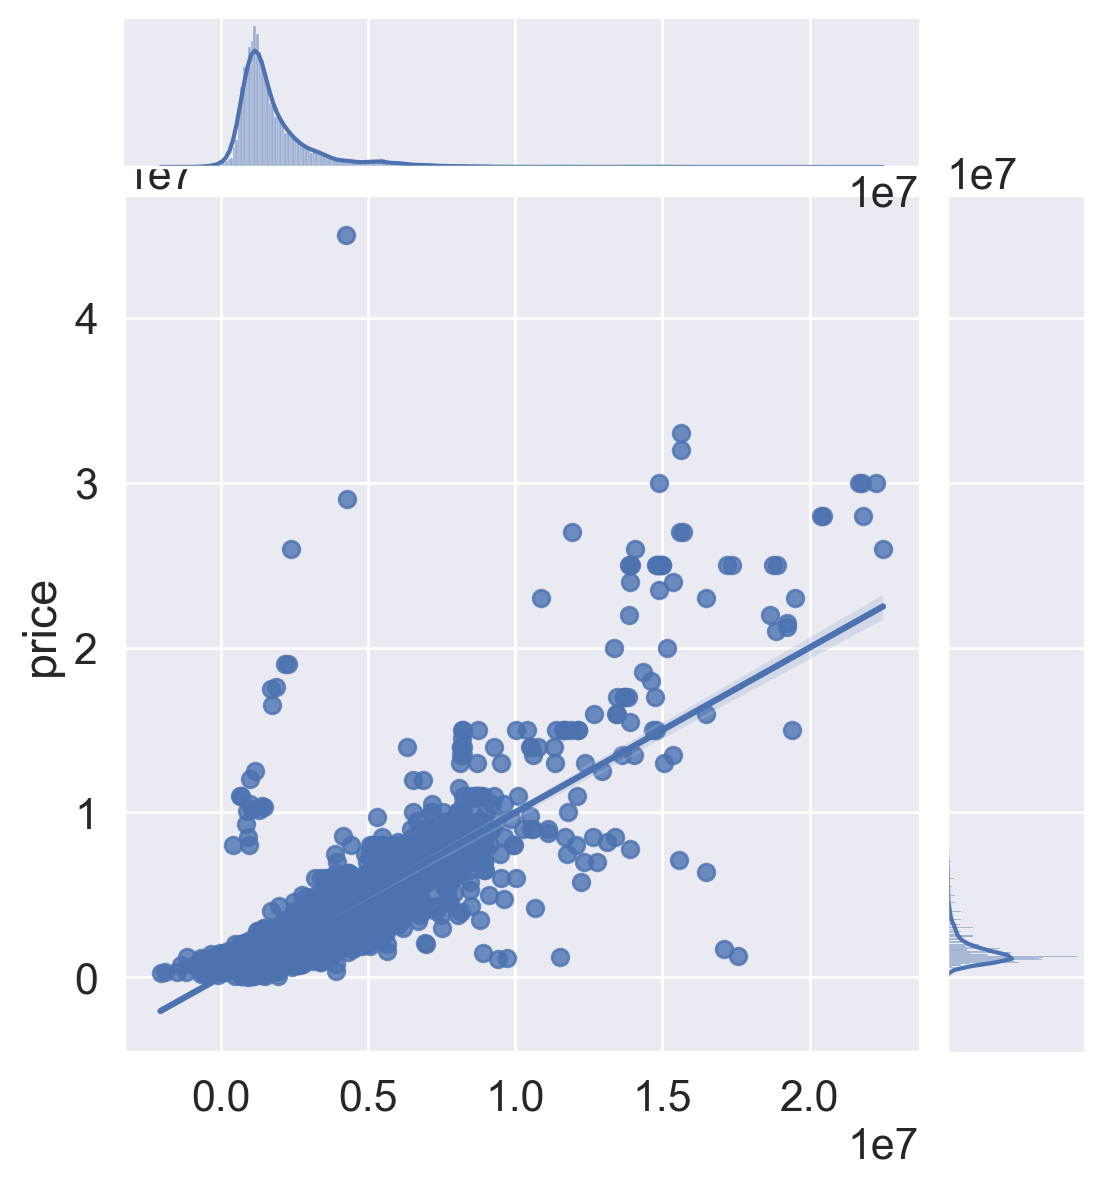

In [77]:
preds = lm.predict(X) # generate predictions (on training data) using fit model

sns.jointplot(x=preds,y=y, kind='reg')

In [78]:
lm.score(X,y)

0.7709577796960787

## Multicollinearity

In [79]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [80]:
 X = X.apply(pd.to_numeric, errors='coerce')

In [81]:
vif = calc_vif(X[['beds','area','distance_to_kindom_tower_Km', 'street_width', 'age']])
vif

,variables,VIF
0,beds,15.023524
1,area,4.453965
2,distance_to_kindom_tower_Km,11.625457
3,street_width,14.515293
4,age,1.517390


In [82]:
X2 = X[['beds','area','distance_to_kindom_tower_Km', 'street_width', 'age']]
#after 
split_and_validate(X2,y)

Linear Regression test R^2: 0.622

CV for Linear model score was: 0.6356377269009222

Ridge Regression test R^2: 0.623

CV for Ridge model was score was: 0.6356378161315004


In [83]:
vif = calc_vif(X[['area','distance_to_kindom_tower_Km', 'street_width', 'age']])
vif

,variables,VIF
0,area,4.168208
1,distance_to_kindom_tower_Km,9.040646
2,street_width,11.872723
3,age,1.444237


In [84]:
X3 = X[['area','distance_to_kindom_tower_Km', 'street_width', 'age']]
#after 
split_and_validate(X3,y)

Linear Regression test R^2: 0.621

CV for Linear model score was: 0.6349410805229112

Ridge Regression test R^2: 0.622

CV for Ridge model was score was: 0.6349411859919872


In [85]:
vif = calc_vif(X[['area','distance_to_kindom_tower_Km', 'age']])
vif

,variables,VIF
0,area,3.372267
1,distance_to_kindom_tower_Km,2.686558
2,age,1.436336


In [86]:
X4 = X[['area','distance_to_kindom_tower_Km', 'age']]

In [87]:
#after 
split_and_validate(X4,y)

Linear Regression test R^2: 0.621

CV for Linear model score was: 0.6349878570691059

Ridge Regression test R^2: 0.622

CV for Ridge model was score was: 0.6349879622251692


## Scaling MinMaxScaler, and StandardScaler

In [88]:
from sklearn.preprocessing import MinMaxScaler

In [89]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
MinMax_scaled = scaler.fit_transform(X)
print(MinMax_scaled)

[[0.84927814 0.         0.5        ... 1.         0.         0.        ]
 [0.93565657 0.         1.         ... 0.         0.         1.        ]
 [0.96126267 0.         0.83333333 ... 0.         1.         0.        ]
 ...
 [0.87476018 0.         0.5        ... 1.         0.         0.        ]
 [0.97371851 0.         0.83333333 ... 0.         1.         0.        ]
 [0.97807953 0.         0.83333333 ... 0.         1.         0.        ]]


In [90]:
#after 
split_and_validate(MinMax_scaled,y)

Linear Regression test R^2: 0.734

CV for Linear model score was: -175330452430530.53

Ridge Regression test R^2: 0.740

CV for Ridge model was score was: 0.7534748178235591


In [91]:
from sklearn.preprocessing import StandardScaler

In [92]:
scaler = StandardScaler()
# transform data
StandardScaler_scaled = scaler.fit_transform(X)
print(StandardScaler_scaled)

[[-0.93946861  0.          0.04347498 ...  2.07104122 -0.71941698
  -0.08407704]
 [ 0.08794365  0.          1.73264114 ... -0.48284891 -0.71941698
  11.89385422]
 [ 0.39251066  0.          1.16958575 ... -0.48284891  1.39001446
  -0.08407704]
 ...
 [-0.63637715  0.          0.04347498 ...  2.07104122 -0.71941698
  -0.08407704]
 [ 0.54066431  0.          1.16958575 ... -0.48284891  1.39001446
  -0.08407704]
 [ 0.59253558  0.          1.16958575 ... -0.48284891  1.39001446
  -0.08407704]]


In [93]:
#after 
split_and_validate(StandardScaler_scaled,y)

Linear Regression test R^2: 0.733

CV for Linear model score was: -1.0228502886772535e+19

Ridge Regression test R^2: 0.740

CV for Ridge model was score was: 0.7522180581105579


In [94]:
from sklearn.preprocessing import LabelEncoder

In [95]:
LabelEncoder.fit_transform(dfa['district'], y)

array([344, 164, 179, ..., 360, 193, 146], dtype=int64)

## PCA

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

In [97]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

In [98]:
X_reduced

array([[ 1.37541832e+00,  2.73008181e+00, -6.44016542e-01, ...,
        -1.77533404e-15, -9.25250055e-17,  3.15036219e-16],
       [ 1.34507453e+00,  2.81629879e+00,  3.24911435e+00, ...,
        -8.78318823e-15,  1.12497889e-14,  5.13264433e-15],
       [-2.20650339e+00,  2.05680688e+00,  4.35792722e-01, ...,
        -7.39774612e-15,  3.91724608e-16,  3.36377773e-16],
       ...,
       [ 1.80767724e+00,  2.00858733e+00, -2.09609032e-01, ...,
         1.62884554e-17, -4.43064668e-17,  2.12562693e-17],
       [-3.32922272e+00,  1.58803867e+00, -2.17640866e-01, ...,
         1.10797091e-16, -2.29028975e-17,  4.47602562e-17],
       [-3.46205095e+00, -3.92354613e-02,  1.43509113e+00, ...,
        -6.05663704e-18,  1.63582866e-17, -3.93688741e-17]])

Text(0.5, 1.0, 'hp')

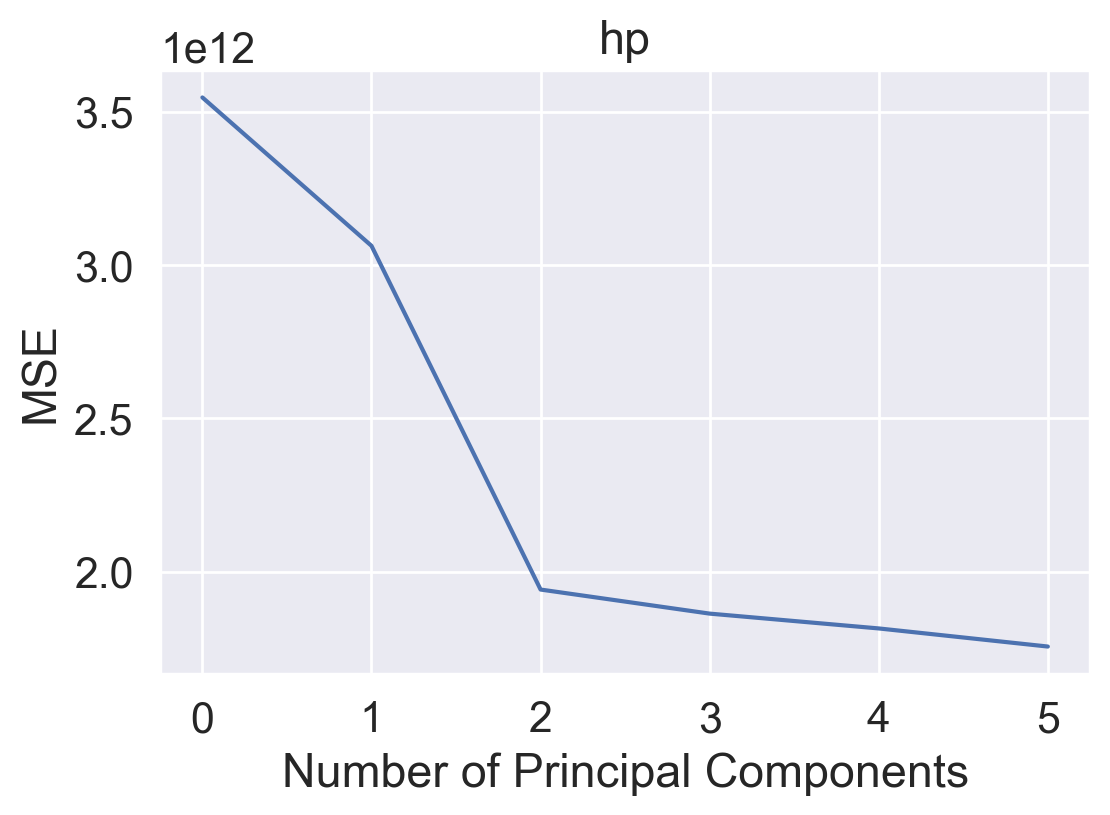

In [99]:
#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

In [100]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 4.24,  7.66, 10.02, 12.26, 14.16, 15.59, 16.9 , 18.08, 19.19,
       20.22, 21.18, 22.1 , 23.  , 23.88, 24.75, 25.61, 26.46, 27.3 ,
       28.14, 28.97, 29.8 , 30.62, 31.44, 32.25, 33.06, 33.87, 34.68,
       35.48, 36.28, 37.08, 37.88, 38.68, 39.48, 40.27, 41.06, 41.85,
       42.64, 43.43, 44.22, 45.01, 45.8 , 46.59, 47.38, 48.17, 48.96,
       49.75, 50.54, 51.33, 52.12, 52.91, 53.7 , 54.48, 55.26, 56.04,
       56.82, 57.6 , 58.38, 59.16, 59.94, 60.72, 61.5 , 62.28, 63.06,
       63.84, 64.62, 65.4 , 66.18, 66.96, 67.74, 68.52, 69.3 , 70.08,
       70.86, 71.64, 72.42, 73.2 , 73.98, 74.76, 75.54, 76.32, 77.1 ,
       77.88, 78.66, 79.44, 80.22, 81.  , 81.78, 82.56, 83.34, 84.12,
       84.9 , 85.68, 86.46, 87.24, 88.01, 88.77, 89.5 , 90.2 , 90.89,
       91.56, 92.21, 92.85, 93.46, 94.06, 94.63, 95.19, 95.72, 96.24,
       96.73, 97.21, 97.64, 98.07, 98.45, 98.83, 99.17, 99.49, 99.72,
       99.82, 99.9 , 99.91, 99.92, 99.93, 99.93, 99.93, 99.93, 99.93,
       99.93, 99.93,

In [101]:
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#scale the training and testing data
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:1]

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:1], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

1697923.3196649328